In [4]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [10]:
mnist_raw = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())

In [11]:
# Pick a sample
sample_idx = 0
img, label = mnist_raw[sample_idx]  # img shape: [1, 28, 28], in [0,1]

# Threshold to binary mask
thresh = 0.5
mask = (img >= thresh).float()
# Upscale mask to 128x128 with nearest neighbor (keeps edges sharp)
mask_up = transforms.Resize((128,128), interpolation=transforms.InterpolationMode.NEAREST)(mask)



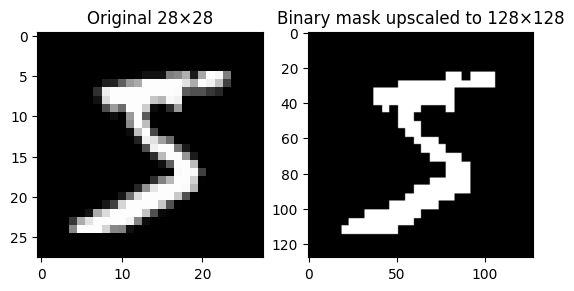

In [12]:
# Visualize
plt.subplot(1,2,1)
plt.imshow(img[0], cmap='gray')
plt.title("Original 28×28")

plt.subplot(1,2,2)
plt.imshow(mask_up[0], cmap='gray')
plt.title("Binary mask upscaled to 128×128")
plt.show()


In [14]:
from scipy.ndimage import distance_transform_edt

def mask_to_sdf(mask: torch.Tensor) -> torch.Tensor:
    """
    Convert a binary mask (1 inside, 0 outside) to a signed distance field.
    mask: torch.Tensor of shape [H, W] or [1, H, W]
    """
    mask_np = mask.squeeze().cpu().numpy().astype(np.uint8)
    
    # Distance outside the object
    dist_out = distance_transform_edt(1 - mask_np)
    # Distance inside the object
    dist_in = distance_transform_edt(mask_np)
    
    sdf = dist_out - dist_in  # negative inside
    return torch.from_numpy(sdf).float()


In [15]:
sdf_field = mask_to_sdf(mask_up)


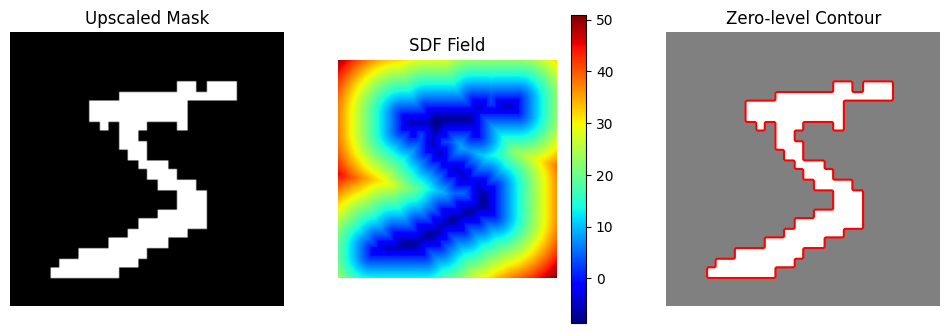

In [16]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Upscaled Mask")
plt.imshow(mask_up.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("SDF Field")
plt.imshow(sdf_field, cmap='jet')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Zero-level Contour")
plt.contour(sdf_field.numpy(), levels=[0], colors='red')
plt.imshow(mask_up.squeeze(), cmap='gray', alpha=0.5)
plt.axis('off')

plt.show()


In [18]:
import numpy as np

def sdf_gradient(sdf):
    # sdf is a 2D NumPy array
    gx, gy = np.gradient(sdf)  # central differences internally
    return gx, gy

# Example:
gx, gy = sdf_gradient(sdf_field)
grad_mag = np.sqrt(gx**2 + gy**2)


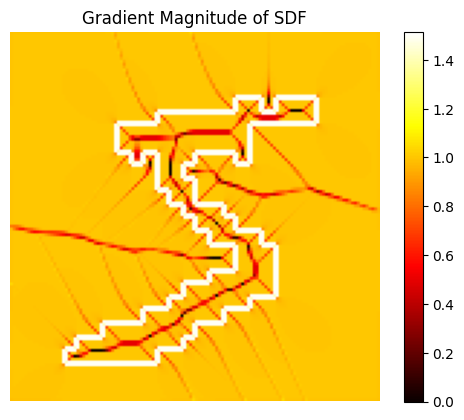

In [19]:
plt.imshow(grad_mag, cmap='hot')
plt.colorbar()
plt.title("Gradient Magnitude of SDF")
plt.axis('off')
plt.show()

In [20]:
import torch
import numpy as np
from scipy.ndimage import binary_closing, gaussian_filter, distance_transform_edt

# 1. Binary mask with mild morphological closing
mask_clean = binary_closing(mask_up.squeeze() >= 0.5, structure=np.ones((2,2)))


In [21]:
# 2. Compute SDF
dist_out = distance_transform_edt(1 - mask_clean)
dist_in  = distance_transform_edt(mask_clean)
sdf = dist_out - dist_in

# 3. Optional: smooth the SDF a little (small sigma)
sdf_smooth = gaussian_filter(sdf, sigma=0.5)

# 4. Normalize for plotting (optional)
sdf_norm = sdf_smooth / np.max(np.abs(sdf_smooth))


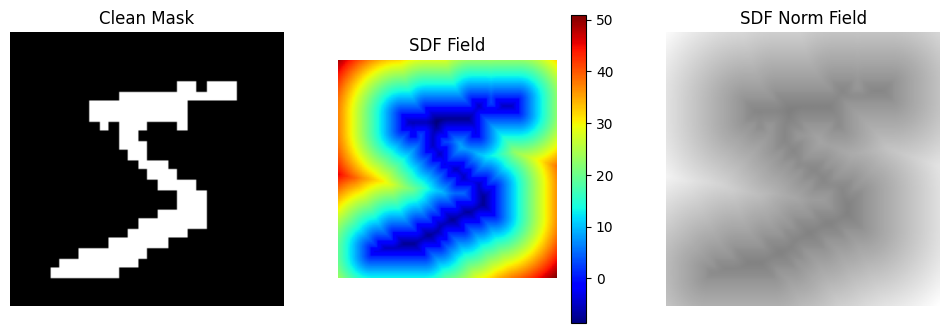

In [32]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Clean Mask")
plt.imshow(mask_clean, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("SDF Field")
plt.imshow(sdf, cmap='jet')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("SDF Norm Field")
plt.imshow(sdf_norm, cmap='gray', alpha=0.5)
plt.axis('off')

plt.show()


# LOL

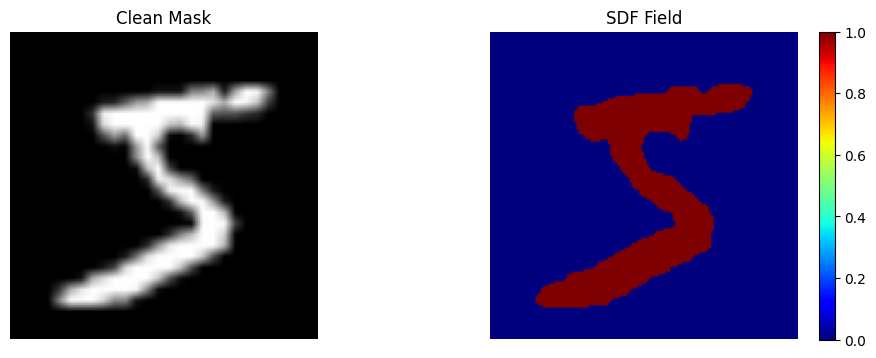

In [21]:
import torch
from torchvision import datasets, transforms

target_size = (128, 128)

# Load MNIST grayscale (no resize here)
mnist = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
img28, label = mnist[0]                   # img28: [1,28,28] in [0,1]

# Resize FIRST (antialiased), then threshold
resize = transforms.Resize(target_size, antialias=True)  # bilinear for PIL under the hood
img128 = resize(img28)                     # [1,128,128], still grayscale
mask_up = (img128 >= 0.3).float()         # binary mask like MetaSDF




# Visualize
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title("Clean Mask")
plt.imshow(img128.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("SDF Field")
plt.imshow(mask_up.squeeze(), cmap='jet')
plt.colorbar()
plt.axis('off')

plt.show()

In [22]:
from scipy.ndimage import distance_transform_edt as edt

mask = (mask_up.squeeze().detach().cpu().numpy()).astype(np.uint8)

# Distances: edt computes, for each ZERO pixel, distance to nearest NON-ZERO pixel
dist_outside = edt(mask == 0)  # distance for background pixels to the digit
dist_inside  = edt(mask == 1)  # distance for foreground pixels to the background

sdf = dist_outside - dist_inside          # NEGATIVE inside (mask==1), POSITIVE outside
# Optional: match MetaSDF scale (divide by image width)
sdf /= float(mask.shape[1])

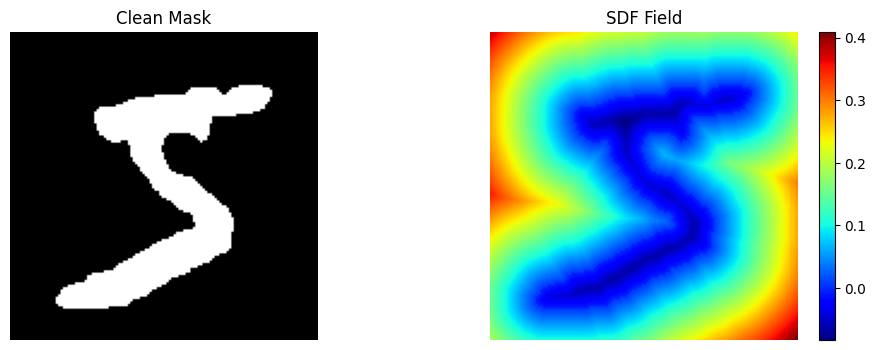

In [24]:

# Visualize
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title("Clean Mask")
plt.imshow(mask.squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("SDF Field")
plt.imshow(sdf.squeeze(), cmap='jet')
plt.colorbar()
plt.axis('off')

plt.show()

In [27]:
import numpy as np

binary = (mask_up.squeeze().cpu().numpy() >= 0.5)
inside  = sdf_field[binary]
outside = sdf_field[~binary]
print(f"inside mean:  {inside.mean():.4f}  (should be < 0)")
print(f"outside mean: {outside.mean():.4f} (should be > 0)")


inside mean:  -0.0310  (should be < 0)
outside mean: 0.1337 (should be > 0)


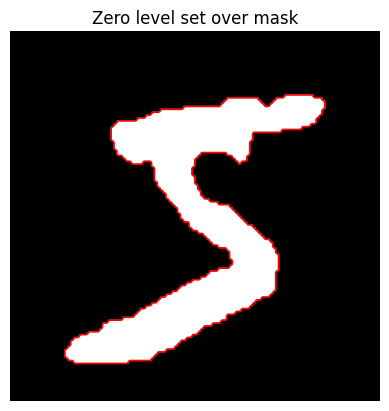

In [28]:
import matplotlib.pyplot as plt
plt.imshow(binary, cmap='gray'); plt.axis('off')
plt.contour(sdf_field, levels=[0.0], colors='red', linewidths=1.2)
plt.title("Zero level set over mask")
plt.show()


In [25]:
sdf_field = sdf

H, W = sdf_field.shape
gy, gx = np.gradient(sdf_field)              # pixel spacing = 1
grad_mag = np.sqrt(gx**2 + gy**2)
print("mean |∇sdf| ≈", grad_mag.mean(), " expected ~", 1.0/W)

# If you prefer to check against ~1, scale back to pixel units:
phi_pixels = sdf_field * W
gy, gx = np.gradient(phi_pixels)
grad_mag_px = np.sqrt(gx**2 + gy**2)
print("mean |∇(sdf*W)| ≈", grad_mag_px.mean(), " expected ~ 1")


mean |∇sdf| ≈ 0.007839767163447618  expected ~ 0.0078125
mean |∇(sdf*W)| ≈ 1.003490196921295  expected ~ 1


In [29]:
import numpy as np

# If you did `sdf /= W` earlier, flip this to True so we scale back to pixel units
sdf_is_normalized = True

H, W = sdf.shape
phi = sdf * W if sdf_is_normalized else sdf  # use pixel units so |∇phi| ≈ 1 away from the interface

# numpy returns [d/dy, d/dx]
gy, gx = np.gradient(phi.astype(np.float32))
grad_mag = np.hypot(gx, gy)

# unit normals pointing outward from the surface
eps = 1e-8
nx = gx / (grad_mag + eps)
ny = gy / (grad_mag + eps)

print(f"grad |∇phi| stats: min={grad_mag.min():.3f}  mean={grad_mag.mean():.3f}  max={grad_mag.max():.3f}")


grad |∇phi| stats: min=0.000  mean=1.003  max=1.707


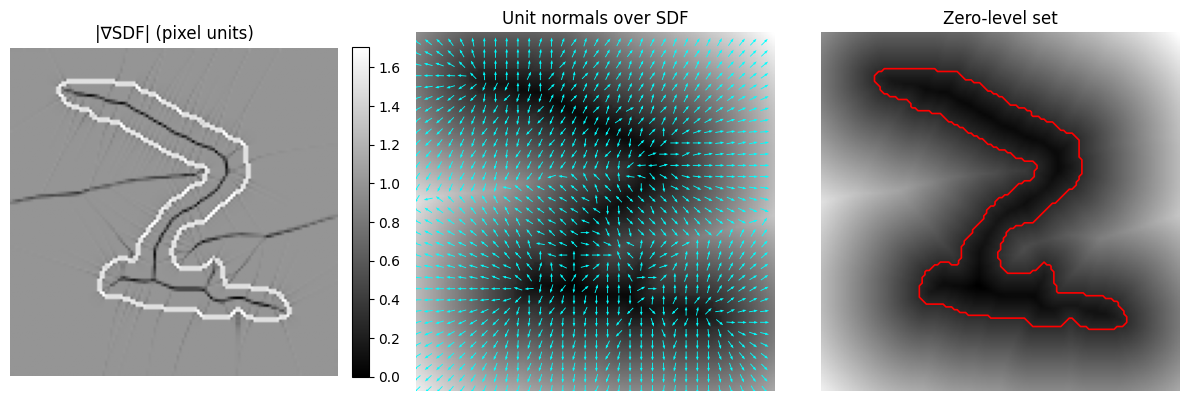

In [30]:
import matplotlib.pyplot as plt

step = 4  # downsample for clearer arrows
Y, X = np.mgrid[0:H, 0:W]

plt.figure(figsize=(12,4))

# |∇phi|
plt.subplot(1,3,1)
plt.title("|∇SDF| (pixel units)")
im = plt.imshow(grad_mag, cmap="gray", origin="lower")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.axis("off")

# normals (quiver) over SDF background
plt.subplot(1,3,2)
plt.title("Unit normals over SDF")
plt.imshow(phi, cmap="gray", origin="lower")
plt.quiver(X[::step, ::step], Y[::step, ::step],
           nx[::step, ::step], ny[::step, ::step],
           color="cyan", pivot="mid", scale=40, headwidth=3, headlength=4)
plt.axis("off")

# zero level set check
plt.subplot(1,3,3)
plt.title("Zero-level set")
plt.imshow(phi, cmap="gray", origin="lower")
plt.contour(phi, levels=[0.0], colors="red", linewidths=1.2)
plt.axis("off")

plt.tight_layout()
plt.show()


In [31]:
# away from the interface the SDF should satisfy |∇phi| ~ 1
band = 2.0  # pixels; ignore a thin band around the interface
mask_far = np.abs(phi) > band
print("mean |∇phi| outside band:", grad_mag[mask_far].mean())


mean |∇phi| outside band: 0.97963005
